In [96]:
import pandas as pd

# Predicting the Sale Price of Bulldozers

## 1. Probem Definition

> Predict price of a bulldozer given its characteristics and prices of a similar bulldozers that were sold previously

## 2. Data

> Blue Book for Bulldozers  

>3 main datasets:  
>- Train.csv is the training set, which contains data through the end of 2011.
> - Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
>- Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

> RMSLE (root mean squared log error) between the actual and predicted auction prices.

**Note**: The goal for most regression evaluation metrics is to minimize the error.

## 4. Features

The key fields are in train.csv are:  
- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [97]:
features_dictionary = pd.read_excel('../data/Data Dictionary.xlsx', index_col=0)
features_dictionary.drop(['Unnamed: 2'], axis=1, inplace=True)
features_dictionary

C:\Users\whyko\miniconda3\envs\doz\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Description
Variable,
SalesID,unique identifier of a particular sale of a ...
MachineID,identifier for a particular machine; machin...
ModelID,identifier for a unique machine model (i.e. ...
datasource,source of the sale record; some sources are...
auctioneerID,"identifier of a particular auctioneer, i.e. ..."
YearMade,year of manufacturer of the Machine
MachineHoursCurrentMeter,current usage of the machine in hours at tim...
UsageBand,"value (low, medium, high) calculated compari..."
Saledate,time of sale


In [98]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [99]:
# set low memory False because of warning
df = pd.read_csv('../data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [101]:
# transpose to see all columns
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [102]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

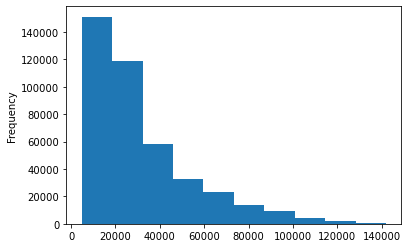

In [103]:
df.SalePrice.plot.hist();

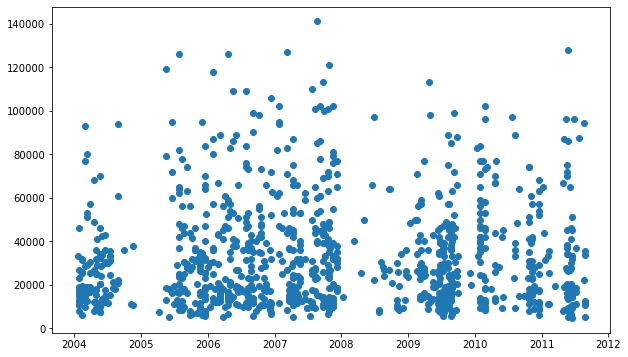

In [104]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])

### Sort DataFrame by saledate

In [105]:
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df_copy = df.copy()

### Feature Engineering

In [106]:
df_copy['saleYear'] = df.saledate.dt.year
df_copy['saleMonth'] = df.saledate.dt.month
df_copy['saleDay'] = df.saledate.dt.day
df_copy['saleDayOfWeek'] = df.saledate.dt.dayofweek
df_copy['saleDayOfYear'] = df.saledate.dt.dayofyear
df_copy['saleIsQuarterEnd'] = df.saledate.dt.is_quarter_end
df_copy['saleIsQuarterStart'] = df.saledate.dt.is_quarter_start

In [107]:
df_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [108]:
df_copy.drop('saledate', axis=1, inplace=True)

## 5. Modeling

* RandomForestRegressor

Model-driven EDA

### Convert strings to categories, impute missing data

In [109]:
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        # print(label)
        df_copy[label] = content.astype('category').cat.as_ordered()

In [110]:
df_copy.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [111]:
df_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [112]:
df_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

### Save preprocessed data

In [113]:
df_copy.to_csv('../data/train_copy.csv', index=False)

In [114]:
df_copy = pd.read_csv('../data/train_copy.csv', low_memory=False)

## Fill missing data

In [115]:
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear
saleIsQuarterEnd
saleIsQuarterStart


In [116]:
# fill categorical values

In [117]:
# fill numeric rows with the medium
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_copy[label+'_is_missing'] = pd.isnull(content)
            # turn categories into numbers and add + 1 (so all values are positive)
            df_copy[label] = pd.Categorical(content).codes + 1

In [118]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 97 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   SalesID                             412698 non-null  int64  
 1   SalePrice                           412698 non-null  float64
 2   MachineID                           412698 non-null  int64  
 3   ModelID                             412698 non-null  int64  
 4   datasource                          412698 non-null  int64  
 5   auctioneerID                        392562 non-null  float64
 6   YearMade                            412698 non-null  int64  
 7   MachineHoursCurrentMeter            147504 non-null  float64
 8   UsageBand                           412698 non-null  int8   
 9   fiModelDesc                         412698 non-null  object 
 10  fiBaseModel                         412698 non-null  object 
 11  fiSecondaryDesc           

In [119]:
df_tmp = df_copy.copy()
df_train = df_tmp[df_tmp.saleYear != 2012].copy()
df_valid = df_tmp[df_tmp.saleYear == 2012].copy

In [120]:
# fill numeric rows with the medium
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_train[label+'_is_missing'] = pd.isnull(content)
            df_train[label] = content.fillna(content.median())

for label, content in df_valid.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_valid[label+'_is_missing'] = pd.isnull(content)
            df_valid[label] = content.fillna(content.median())

C:\Users\whyko\AppData\Local\Temp\ipykernel_9756\2178447973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label+'_is_missing'] = pd.isnull(content)
C:\Users\whyko\AppData\Local\Temp\ipykernel_9756\2178447973.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label] = content.fillna(content.median())
C:\Users\whyko\AppData\Local\Temp\ipykernel_9756\2178447973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [121]:
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train.SalePrice
X_valid, y_valid = df_valid.drop('SalePrice', axis=1), df_train.SalePrice